#### Part I: Import modules and read data

In [1]:
import ast
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle

from collections import Counter
from pprint import pprint

In [2]:
ents = pd.read_pickle(os.getcwd() + '/Pickle/all_entities.pkl')
ents.shape

(284500, 13)

In [3]:
rels = pd.read_pickle(os.getcwd() + '/Pickle/all_rels.pkl')
rels.shape

(1230815, 15)

In [4]:
filtered_data = pd.read_pickle(os.getcwd() + '/Pickle/filtered_org_match.pkl')
filtered_data.shape

(7454, 18)

In [5]:
matched_names_res = {}

with open(os.getcwd() + '/Pickle/matched_names.pickle', 'rb') as pkl:
    matched_names_res = pickle.load(pkl)
    
matched_name_df = pd.DataFrame(list(matched_names_res.items())).rename(columns = {0: 'ls_id', 1: 'bp_id'})  # create df of matched name IDs
matched_name_df.shape

(118659, 2)

In [6]:
matched_name_df_exploded = matched_name_df.explode('bp_id')
matched_name_df_exploded.head()

,ls_id,bp_id
0,262146,998678
1,262147,636330
2,262150,934460
2,262150,3191192
3,262154,638094


In [7]:
bipartite_all = nx.read_gpickle(os.getcwd() + '/Pickle/bipartite-all010420.pickle')
bipartite_all.number_of_nodes()

4054832

In [8]:
filtered_data.head()[['ls_id', 'bp_id', 'ls_rels', 'bp_rels']]

,ls_id,bp_id,ls_rels,bp_rels
1236,14713,6822486,711,9
1252,14730,6830462,931,7
1284,14922,8904282,18,5
1285,14924,7871420,406,18
1286,14925,7513160,147,34


#### Part II: Forward Matching

i.e. Adding to LittleSis

In [9]:
# x is the current org
def forwardMatch(x_ls_id):
    x_bp_id = filtered_data[filtered_data['ls_id'] == x_ls_id]['bp_id'].iloc[0]  # get corresponding bp_id
    
    # get 'person' relationships for x from LittleSis
    x_ls_rels = rels[rels['entity1_id'].isin([x_ls_id]) | rels['entity2_id'].isin([x_ls_id])]  # all LittleSis relations for x
    related_to_x_ls_id = x_ls_rels[x_ls_rels['entity1_id'] != x_ls_id]['entity1_id'].append(x_ls_rels[x_ls_rels['entity2_id'] != x_ls_id]['entity2_id']).unique()  # LittleSis IDs for all ents related to x
    related_to_x_ls = ents[ents['id'].isin(related_to_x_ls_id)]
    related_to_x_ls_names = related_to_x_ls[related_to_x_ls['primary_ext'] == 'Person'][['id', 'name']].rename(columns = {'id': 'ls_id'})
    related_to_x_ls_names.reset_index(drop = True, inplace = True)
    
    if related_to_x_ls_names.shape[0] == 0:  # if true return none else continue
        return None
    
    # get 'person' relationships for x from bipartite-all
    related_to_x_bp = {}
    
    for i in bipartite_all[x_bp_id]:
        related_to_x_bp[i] = bipartite_all.nodes[i]['name']
        
    related_to_x_bp_names = pd.DataFrame(list(related_to_x_bp.items())).rename(columns = {0: 'bp_id', 1: 'name'})
    
    all_x_matches = matched_name_df[matched_name_df['ls_id'].isin(related_to_x_ls_names['ls_id'])]
    all_x_matches_exploded = all_x_matches.explode('bp_id')
    
    final = all_x_matches_exploded[all_x_matches_exploded['bp_id'].isin(related_to_x_bp_names['bp_id'])].set_index('ls_id').join(related_to_x_ls_names.set_index('ls_id'), on = 'ls_id', lsuffix = '_left', rsuffix = '_right').reset_index().set_index('bp_id').join(related_to_x_bp_names.set_index('bp_id'), on = 'bp_id', lsuffix = '_ls', rsuffix = '_bp').reset_index()
    
#     print(final.to_dict())

    return final.to_dict()

In [8]:
abc = filtered_data[filtered_data['ls_id'].isin([15367, 33551])].copy()  # sample data for trying matching
abc

#### Part III: Reverse Matching

i.e. Adding to bipartite-all data

In [11]:
# x is the current org
def reverseMatch(x_ls_id):
    x_bp_id = filtered_data[filtered_data['ls_id'] == x_ls_id]['bp_id'].iloc[0]  # get corresponding bp_id
    
    # get 'person' relationships for x from LittleSis
    x_ls_rels = rels[rels['entity1_id'].isin([x_ls_id]) | rels['entity2_id'].isin([x_ls_id])]  # all LittleSis relations for x
    related_to_x_ls_id = x_ls_rels[x_ls_rels['entity1_id'] != x_ls_id]['entity1_id'].append(x_ls_rels[x_ls_rels['entity2_id'] != x_ls_id]['entity2_id']).unique()  # LittleSis IDs for all ents related to x
    related_to_x_ls = ents[ents['id'].isin(related_to_x_ls_id)]
    related_to_x_ls_names = related_to_x_ls[related_to_x_ls['primary_ext'] == 'Person'][['id', 'name']].rename(columns = {'id': 'ls_id'})
    related_to_x_ls_names.reset_index(drop = True, inplace = True)
    
    if related_to_x_ls_names.shape[0] == 0:  # if true return none else continue
        return None
    
    # get 'person' relationships for x from bipartite-all
    related_to_x_bp = {}
    
    for i in bipartite_all[x_bp_id]:
        related_to_x_bp[i] = bipartite_all.nodes[i]['name']
        
    related_to_x_bp_names = pd.DataFrame(list(related_to_x_bp.items())).rename(columns = {0: 'bp_id', 1: 'name'})
    
    all_x_matches_rev = matched_name_df_exploded[matched_name_df_exploded['bp_id'].isin(related_to_x_bp_names['bp_id'])]
    final = all_x_matches_rev.set_index('ls_id').join(ents.rename(columns = {'id': 'ls_id'}).set_index('ls_id'), on = 'ls_id', lsuffix = '_left', rsuffix = '_right').reset_index().set_index('bp_id').join(related_to_x_bp_names.set_index('bp_id'), on = 'bp_id', lsuffix = '_ls', rsuffix = '_bp').reset_index()[['bp_id', 'ls_id', 'name_ls', 'name_bp']]
    
    return final.to_dict()

In [12]:
abc['rev'] = abc['ls_id'].apply(reverseMatch)
abc

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev
1435,15367,NORTHEASTERN UNIVERSITY,6819740,NORTHEASTERN UNIVERSITY,1.0,None,NaN,"{'Org': {'name_nick': None, 'name': 'Northeast...",None,Org,[Northeastern University],None,"[Organization, School]",2020-06-15T21:58:42Z,None,None,79,69,"{'bp_id': {0: 112459, 1: 295562, 2: 252548, 3:..."
6493,33551,BILL & MELINDA GATES FOUNDATION,7863433,BILL & MELINDA GATES FOUNDATION,1.0,None,NaN,"{'Org': {'name_nick': None, 'name': 'Bill & Me...",None,Org,"[Bill & Melinda Gates Foundation, Bill and Mel...",Family foundation of Microsoft founder Bill Gates,"[Organization, Philanthropy]",2020-07-14T02:25:29Z,None,None,420,19,"{'bp_id': {0: 809124, 1: 516547, 2: 2725019, 3..."


In [13]:
filtered_data['rev'] = filtered_data['ls_id'].appy(reverseMatch)

Save results:

In [14]:
# filtered_data.to_pickle(os.getcwd() + '/Pickle/filtered_org_match_rev.pkl')
# print('Done')

#### Part IV: Analysing Results

In [9]:
# fil_dat_rev = pd.read_pickle(os.getcwd() + '/Pickle/filtered_org_match_rev.pkl')  # filtered_data with the rev column
fil_dat_rev = pd.read_csv(os.getcwd() + '/Data/filtered_org_match_rev.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
fil_dat_rev.shape

(7426, 19)

Note the following changes:

1. filtered_data['bp_id'][114] = 7286871  #corrected CMU
2. filtered_data['match_name'][114] = 'CARNEGIE MELLON UNIVERSITY (CMU)'
3. filtered_data['bp_id'][854]= 8425574  #corrected kaiser family foundation

In [10]:
# fil_dat_rev.iloc[114, 2]

In [11]:
# fil_dat_rev[fil_dat_rev['bp_id'] == 7286871]

In [12]:
# fil_dat_rev[fil_dat_rev['bp_id'] == 8425574]

In [13]:
fil_dat_rev.head()

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev
0,14713,HARVARD LAW SCHOOL,6822486,HARVARD LAW REVIEW ASSOCIATION,0.705592,NaN,14730.0,"{'Org': {'name_nick': None, 'name': 'Harvard L...",http://www.law.harvard.edu,Org,"['Harvard Law School', 'Harvard University Law...",NaN,"['Organization', 'School']",2020-07-12T23:23:57Z,NaN,NaN,711,9,"{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, ..."
1,14730,HARVARD UNIVERSITY,6830462,HARVARD UNIVERSITY BAND INC,0.853769,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Harvard U...",http://www.harvard.edu,Org,"['Harvard College', 'Harvard Corporation', 'Ha...","Elite private university located in Cambridge, MA","['Organization', 'School']",2020-07-12T23:50:00Z,1636-00-00,NaN,931,7,"{'bp_id': {0: 26508, 1: 26508, 2: 26508}, 'ls_..."
2,14922,UNIVERSITY OF NEBRASKA LINCOLN,8904282,UNIVERSITY PROGRAM COUNCIL UNIVERSITY OF NEBRA...,0.844771,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",NaN,Org,"['University of Nebraska - Lincoln', 'Universi...",NaN,"['Organization', 'School']",2019-12-13T19:33:21Z,NaN,NaN,18,5,"{'bp_id': {}, 'ls_id': {}, 'name_ls': {}, 'nam..."
3,14924,COLUMBIA UNIVERSITY,7871420,COLUMBIA INTERNATIONAL UNIVERSITY,0.909055,Columbia University was founded in 1754 as Kin...,NaN,"{'Org': {'name_nick': None, 'name': 'Columbia ...",http://www.columbia.edu/index.html,Org,"['Columbia University', 'Columbia University i...",Oldest institution of higher learning in the s...,"['Organization', 'School']",2020-07-10T18:37:07Z,1754-00-00,NaN,406,18,"{'bp_id': {0: 203090}, 'ls_id': {0: 61002}, 'n..."
4,14925,UNIVERSITY OF ILLINOIS,7513160,UNIVERSITY OF ILLINOIS FOUNDATION,0.961337,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",http://www.uillinois.edu/,Org,"['University of Illinois', 'University of Illi...",One of the original 37 public land-grant insti...,"['Organization', 'School']",2020-05-04T14:54:31Z,1867-00-00,NaN,147,34,"{'bp_id': {0: 786376, 1: 786366, 2: 202359, 3:..."


The 'rev' col is a string because the data was in a CSV:

In [14]:
type(fil_dat_rev.iloc[0, -1])

str

Count number of null values:

In [15]:
fil_dat_rev['rev'].isna().sum()

2563

Convert non-null values to dicts:

In [16]:
fil_dat_rev['rev'] = fil_dat_rev['rev'].apply(lambda x: x if pd.isna(x) else ast.literal_eval(x))
type(fil_dat_rev.iloc[0, -1])

dict

In [17]:
fil_dat_rev.iloc[0, -1]

{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, 3: 3127936},
 'ls_id': {0: 68424, 1: 75935, 2: 164462, 3: 200080},
 'name_ls': {0: 'G Marshall Moriarty',
  1: 'Martha L Minow',
  2: 'Seth Berliner',
  3: 'Carol S Steiker'},
 'name_bp': {0: 'MARSHALL MORIARTY',
  1: 'MARTHA MINOW',
  2: 'SETH BERLINER VOL 131',
  3: 'CAROL STEIKER'}}

In [18]:
fil_dat_rev['rev_len'] = fil_dat_rev['rev'].apply(lambda x: 0 if pd.isna(x) else (len(x['bp_id']) if 'bp_id' in x else 0))
fil_dat_rev.head()

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,aliases,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev,rev_len
0,14713,HARVARD LAW SCHOOL,6822486,HARVARD LAW REVIEW ASSOCIATION,0.705592,NaN,14730.0,"{'Org': {'name_nick': None, 'name': 'Harvard L...",http://www.law.harvard.edu,Org,"['Harvard Law School', 'Harvard University Law...",NaN,"['Organization', 'School']",2020-07-12T23:23:57Z,NaN,NaN,711,9,"{'bp_id': {0: 2923632, 1: 479006, 2: 3127938, ...",4
1,14730,HARVARD UNIVERSITY,6830462,HARVARD UNIVERSITY BAND INC,0.853769,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Harvard U...",http://www.harvard.edu,Org,"['Harvard College', 'Harvard Corporation', 'Ha...","Elite private university located in Cambridge, MA","['Organization', 'School']",2020-07-12T23:50:00Z,1636-00-00,NaN,931,7,"{'bp_id': {0: 26508, 1: 26508, 2: 26508}, 'ls_...",3
2,14922,UNIVERSITY OF NEBRASKA LINCOLN,8904282,UNIVERSITY PROGRAM COUNCIL UNIVERSITY OF NEBRA...,0.844771,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",NaN,Org,"['University of Nebraska - Lincoln', 'Universi...",NaN,"['Organization', 'School']",2019-12-13T19:33:21Z,NaN,NaN,18,5,"{'bp_id': {}, 'ls_id': {}, 'name_ls': {}, 'nam...",0
3,14924,COLUMBIA UNIVERSITY,7871420,COLUMBIA INTERNATIONAL UNIVERSITY,0.909055,Columbia University was founded in 1754 as Kin...,NaN,"{'Org': {'name_nick': None, 'name': 'Columbia ...",http://www.columbia.edu/index.html,Org,"['Columbia University', 'Columbia University i...",Oldest institution of higher learning in the s...,"['Organization', 'School']",2020-07-10T18:37:07Z,1754-00-00,NaN,406,18,"{'bp_id': {0: 203090}, 'ls_id': {0: 61002}, 'n...",1
4,14925,UNIVERSITY OF ILLINOIS,7513160,UNIVERSITY OF ILLINOIS FOUNDATION,0.961337,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Universit...",http://www.uillinois.edu/,Org,"['University of Illinois', 'University of Illi...",One of the original 37 public land-grant insti...,"['Organization', 'School']",2020-05-04T14:54:31Z,1867-00-00,NaN,147,34,"{'bp_id': {0: 786376, 1: 786366, 2: 202359, 3:...",15


In [19]:
fil_dat_rev.sort_values(by = 'rev_len', ascending = False).head(10)[['ls_id', 'bp_id', 'name', 'match_name', 'match_value', 'rev_len']]  #, 'ls_rels', 'bp_rels']]

,ls_id,bp_id,name,match_name,match_value,rev_len
772,38098,6822382,DANA FARBER CANCER INSTITUTE,DANA FARBER CANCER INSTITUTE INC,1.000000,248
1018,40390,7204643,BAY AREA COUNCIL ECONOMIC INSTITUTE,BAY AREA COUNCIL,0.763614,212
4262,132483,8147414,SOUTHWESTERN MEDICAL FOUNDATION,SOUTHWESTERN MEDICAL FOUNDATION,1.000000,137
656,37068,6913911,THE PARTNERSHIP FOR NEW YORK CITY INC,THE PARTNERSHIP FOR NEW YORK CITY INC,1.000000,135
158,33171,7794249,BROOKINGS INSTITUTION,BROOKINGS INSTITUTION,1.000000,114
1214,43032,7450788,MUSEUM OF SCIENCE AND INDUSTRY CHICAGO,MUSEUM OF SCIENCE AND INDUSTRY,0.857128,111
460,34601,7450797,CHICAGO SYMPHONY ORCHESTRA,CHICAGO SYMPHONY ORCHESTRA,1.000000,110
2041,68385,7293838,THE AMERICAN IRELAND FUND,THE AMERICAN IRELAND FUND,1.000000,108
1144,41975,7102038,DREXEL UNIVERSITY,DREXEL UNIVERSITY,1.000000,106
936,39654,6855376,JOHN F KENNEDY PRESIDENTIAL LIBRARY AND MUSEUM,JOHN FITZGERALD KENNEDY LIBRARY FOUNDATION INC,0.546449,104


In [20]:
# plt.hist(fil_dat_rev[fil_dat_rev['rev_len'] > 0]['rev_len'], bins = 20, color = '#9433ff')
# plt.yscale('log')
# plt.title('Distro of Number of Name Matches')
# plt.xlabel('Number')
# plt.ylabel('Log Count')
# plt.show()
# plt.close()

In [21]:
# plt.scatter(fil_dat_rev[fil_dat_rev['rev_len'] > 0]['match_value'], fil_dat_rev[fil_dat_rev['rev_len'] > 0]['rev_len'], alpha = 0.4, color = '#9433ff')
# plt.title('Number of Name Matches vs Match Value')
# plt.xlabel('Match Value')
# plt.ylabel('Number of Name Matches')
# plt.show()
# plt.close()

Getting all universities using [NTEE code](https://nccs.urban.org/publication/irs-activity-codes):

In [22]:
unis = fil_dat_rev[fil_dat_rev['bp_id'].apply(lambda x: True if bipartite_all.nodes[x]['bipartite'] == 0 and (bipartite_all.nodes[x]['ntee_code'].startswith('B4') or bipartite_all.nodes[x]['ntee_code'].startswith('B5')) else False)]  # returns true if ent is listed in bipartite-all as an org (bipartite = 0) and NTEE code is B4_ or B5_, else false
unis.shape

(1030, 20)

University stats:

In [23]:
pd.concat([unis[['match_value', 'rev_len']].describe(), fil_dat_rev[['match_value', 'rev_len']].describe().rename(columns = {'match_value': 'overall_match_value', 'rev_len': 'overall_rev_len'})], axis = 1)

,match_value,rev_len,overall_match_value,overall_rev_len
count,1030.000000,1030.000000,7426.000000,7426.000000
mean,0.833878,14.014563,0.817307,7.710207
std,0.220814,18.450753,0.227022,14.358181
min,0.196042,0.000000,0.049361,0.000000
25%,0.684627,0.000000,0.663806,0.000000
50%,0.981536,8.000000,0.944296,1.000000
75%,1.000000,21.000000,1.000000,10.000000
max,1.000000,106.000000,1.000000,248.000000


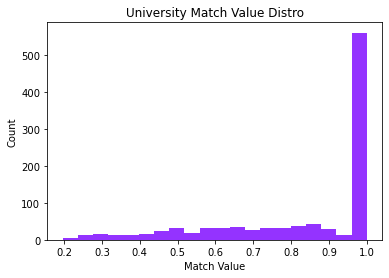

In [24]:
# plt.hist(fil_dat_rev['match_value'], bins = 20, color = '#00788c')
plt.hist(unis['match_value'], bins = 20, color = '#9433ff')
plt.title('University Match Value Distro')
plt.xlabel('Match Value')
plt.ylabel('Count')
plt.show()
plt.close()

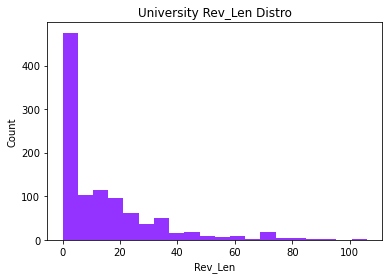

In [25]:
plt.hist(unis['rev_len'], bins = 20, color = '#9433ff')
plt.title('University Rev_Len Distro')
plt.xlabel('Rev_Len')
plt.ylabel('Count')
plt.show()
plt.close()

In [26]:
unis_with_names = unis[unis['rev_len'] > 0].copy()  # .copy() to prevent warning when creating type_breakdown col, maybe apply a match_value filter here?
unis_with_names.shape

(686, 20)

Remember: One person can have multiple types

In [27]:
def breakdownCounter(x):  # x is the dict stored in the rev col of fil_dat_rev
#     reqd_types = {'Business Person': 0, 'Lobbyist': 0, 'Academic': 0, 'Political Candidate': 0, 'Lawyer': 0, 'Public Official': 0, 'Elected Representative': 0, 'Media Personality': 0, 'Public Intellectual': 0}
    reqd_types = ['Business Person', 'Lobbyist', 'Academic', 'Political Candidate', 'Lawyer', 'Public Official', 'Elected Representative', 'Media Personality', 'Public Intellectual']  # types of people we're interested in

    related_ls_ids = x['ls_id'].values()  # get the LittleSis IDs of the people related to the current org
    
    all_counts = ents[ents['id'].isin(related_ls_ids)]['types'].explode().value_counts()  # count all types listing for those IDs
    
    idx = all_counts.index.isin(reqd_types)  # get indices of types we're interested in 
    
#     print(all_counts[idx].to_dict())

    return all_counts[idx].to_dict()  # convert series to a dict and return

In [28]:
abc = unis_with_names.head().copy()  # abc is the sample
# abc

In [29]:
abc['type_breakdown'] = abc['rev'].apply(breakdownCounter)
abc

,ls_id,name,bp_id,match_name,match_value,summary,parent_id,extensions,website,primary_ext,...,blurb,types,updated_at,start_date,end_date,ls_rels,bp_rels,rev,rev_len,type_breakdown
3,14924,COLUMBIA UNIVERSITY,7871420,COLUMBIA INTERNATIONAL UNIVERSITY,0.909055,Columbia University was founded in 1754 as Kin...,NaN,"{'Org': {'name_nick': None, 'name': 'Columbia ...",http://www.columbia.edu/index.html,Org,...,Oldest institution of higher learning in the s...,"['Organization', 'School']",2020-07-10T18:37:07Z,1754-00-00,NaN,406,18,"{'bp_id': {0: 203090}, 'ls_id': {0: 61002}, 'n...",1,{'Business Person': 1}
6,14928,TRINITY UNIVERSITY OF SAN ANTONIO,8108252,OUR LADY OF THE LAKE UNIVERSITY OF SAN ANTONIO,0.576802,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Trinity U...",NaN,Org,...,NaN,"['Organization', 'School']",2019-10-26T17:59:14Z,NaN,NaN,7,32,"{'bp_id': {0: 486509, 1: 486513, 2: 33952}, 'l...",3,"{'Political Candidate': 1, 'Elected Representa..."
7,14931,JOHNS HOPKINS UNIVERSITY,7746598,JOHNS HOPKINS UNIVERSITY,1.000000,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Johns Hop...",NaN,Org,...,"Baltimore, Maryland","['Organization', 'School']",2020-06-20T01:45:39Z,NaN,NaN,191,60,"{'bp_id': {0: 404004, 1: 27883, 2: 397820, 3: ...",43,"{'Business Person': 19, 'Lawyer': 3, 'Public O..."
14,14944,WASHINGTON UNIVERSITY IN ST LOUIS,7644970,ST LOUIS UNIVERSITY,0.792701,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Washingto...",http://www.wustl.edu/,Org,...,A private research university located in St. L...,"['Organization', 'School']",2020-07-11T14:21:34Z,1853-00-00,NaN,216,68,"{'bp_id': {0: 582584, 1: 920761, 2: 53938, 3: ...",28,"{'Business Person': 9, 'Academic': 4, 'Lobbyis..."
15,14946,FINCH COLLEGE,6958634,MEDAILLE COLLEGE,0.202467,NaN,NaN,"{'Org': {'name_nick': None, 'name': 'Finch Col...",NaN,Org,...,NaN,"['Organization', 'School']",2020-01-23T18:23:21Z,NaN,NaN,3,23,"{'bp_id': {0: 382953, 1: 621422, 2: 128940, 3:...",18,{'Business Person': 6}


In [30]:
def plotBreakdown(type_breakdown):
    counter = Counter()
    
    # count total occurences of each type
    for type_dict in type_breakdown:
        counter.update(type_dict)
        
    pprint(counter)
        
    l = list(zip(*counter.most_common()))  # creates a list of tuples of the counts in desc order
    
#     plt.bar(l[0], l[1], color = '#9433ff')
    plt.barh(l[0], l[1], color = '#9433ff')
    plt.title('Distribution of People for Universities Boards')
#     plt.xlabel('Type')
#     plt.ylabel('Count')
#     plt.xticks(rotation = 90)
    plt.xlabel('Count')
    plt.ylabel('Type')
    plt.show()
    plt.close()

Counter({'Business Person': 35,
         'Academic': 5,
         'Public Official': 4,
         'Political Candidate': 3,
         'Elected Representative': 3,
         'Lawyer': 3,
         'Lobbyist': 3,
         'Media Personality': 2})


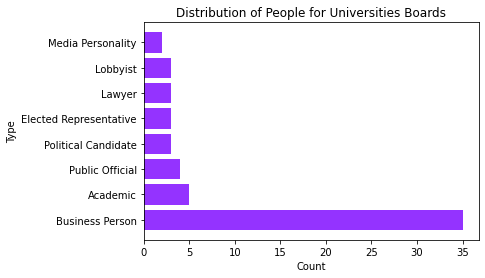

In [31]:
plotBreakdown(abc['type_breakdown'].tolist())  # for the sample

Counter({'Business Person': 5459,
         'Lawyer': 630,
         'Lobbyist': 591,
         'Academic': 558,
         'Political Candidate': 544,
         'Public Official': 457,
         'Elected Representative': 313,
         'Media Personality': 100,
         'Public Intellectual': 26})


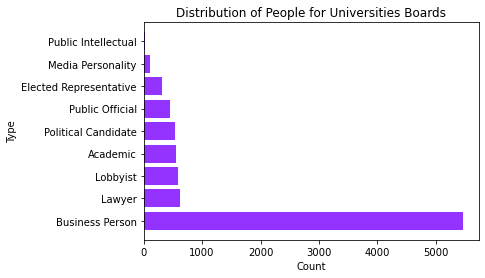

In [32]:
unis_with_names['type_breakdown'] = unis_with_names['rev'].apply(breakdownCounter)

plotBreakdown(unis_with_names['type_breakdown'].tolist())  # overall breakdown

Get the breakdown for a required subset:

In [33]:
def uniSubsetBreakdown(ls_ids):
    uni_subset = unis_with_names[unis_with_names['ls_id'].isin(ls_ids)].copy()  # create the subset
    
    uni_subset['type_breakdown'] = uni_subset['rev'].apply(breakdownCounter)
    
    plotBreakdown(uni_subset['type_breakdown'].tolist())

Counter({'Business Person': 43,
         'Lawyer': 5,
         'Political Candidate': 5,
         'Public Official': 4,
         'Elected Representative': 4,
         'Academic': 3,
         'Media Personality': 2})


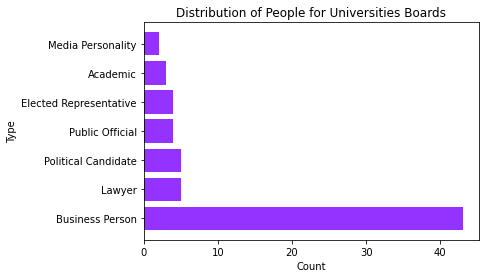

In [34]:
subset_ls_ids = [14931, 15367]  # LittleSis IDs of Johns Hopkins, Northeastern

uniSubsetBreakdown(subset_ls_ids)  # plot the breakdown for the selected subset